In [6]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as si

# Walmart Data

In [7]:
walmart_data = yf.download("WMT", start="2022-04-01", end="2024-04-01")

[*********************100%%**********************]  1 of 1 completed


# Stock Price Movement

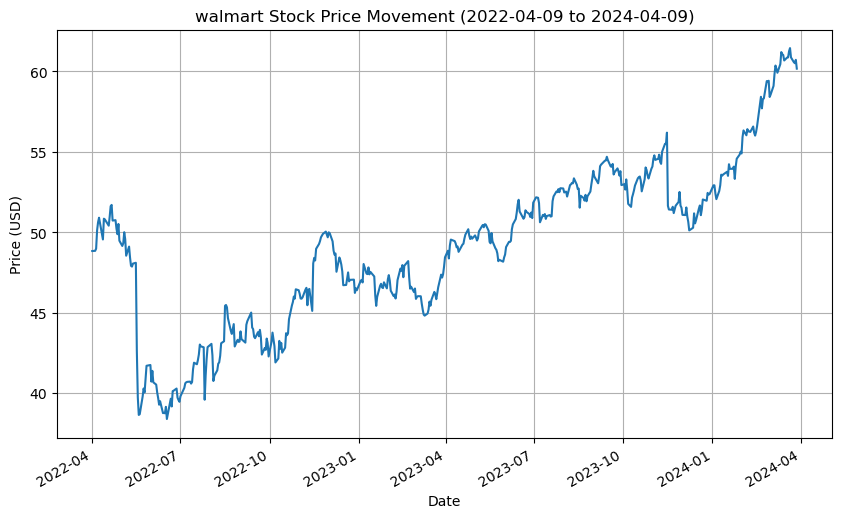

In [8]:
plt.figure(figsize=(10, 6))
walmart_data['Adj Close'].plot()
plt.title('walmart Stock Price Movement (2022-04-09 to 2024-04-09)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

In [9]:
data =  walmart_data['Adj Close']
data.describe().round()

count    500.0
mean      49.0
std        5.0
min       38.0
25%       46.0
50%       49.0
75%       53.0
max       61.0
Name: Adj Close, dtype: float64

In [10]:
data.diff()

Date
2022-04-01         NaN
2022-04-04    0.009708
2022-04-05    0.139061
2022-04-06    1.138340
2022-04-07    0.501263
                ...   
2024-03-22   -0.580002
2024-03-25   -0.299999
2024-03-26   -0.060001
2024-03-27    0.210003
2024-03-28   -0.550003
Name: Adj Close, Length: 500, dtype: float64

# ANNUALISED AVERAGE RETURN AND ANNUALISED STANDARD DEVIATION

In [43]:
returns = walmart_data['Adj Close'].pct_change().dropna()
annualized_return = np.mean(returns) * 252

In [44]:
annualized_std_dev = np.std(returns) * np.sqrt(252)

In [45]:
print("Annualized Average Return:", annualized_return)
print("Annualized Standard Deviation:", annualized_std_dev)

Annualized Average Return: 0.1286721339912671
Annualized Standard Deviation: 0.21361085645169567


# BINOMIAL TREE PRICING

In [46]:
S0 = walmart_data['Adj Close'].iloc[-1]  
K = 70
T = 1  
r = 0.043  
sigma = annualized_std_dev  
N = 5  
payoff = "put"

In [47]:
dT = float(T) / N                             
u = np.exp(sigma * np.sqrt(dT))                 
d = 1.0 / u   

In [48]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1): 
    for i in range(z):  
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1  

In [49]:
S

array([[60.16999817, 66.20152758, 72.83766641, 80.13902158, 88.17227537,
        97.01079438],
       [ 0.        , 54.68799304, 60.16999817, 66.20152758, 72.83766641,
        80.13902158],
       [ 0.        ,  0.        , 49.7054458 , 54.68799304, 60.16999817,
        66.20152758],
       [ 0.        ,  0.        ,  0.        , 45.17685153, 49.7054458 ,
        54.68799304],
       [ 0.        ,  0.        ,  0.        ,  0.        , 41.06085121,
        45.17685153],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        37.31985397]])

In [50]:
a = np.exp(r * dT)    
p = (a - d)/ (u - d)  
q = 1.0 - p  
p

0.5212733387764024

In [51]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         3.79847242],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        15.31200696],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        24.82314847],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        32.68014603]])

In [52]:
for j in range(N-1, -1, -1): 
    for i in range(j+1):  
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1]) 
V

array([[ 9.59612985,  6.01537588,  2.96383636,  0.85568583,  0.        ,
         0.        ],
       [ 0.        , 13.66825354,  9.44664813,  5.31282101,  1.80285857,
         0.        ],
       [ 0.        ,  0.        , 18.51165253, 14.11830225,  9.23058303,
         3.79847242],
       [ 0.        ,  0.        ,  0.        , 23.62944376, 19.6951354 ,
        15.31200696],
       [ 0.        ,  0.        ,  0.        ,  0.        , 28.33972999,
        24.82314847],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        32.68014603]])

In [53]:
print('European ' + payoff, str( V[0,0]))

European put 9.596129845100277


In [54]:
if payoff =="call":
    for j in range(N-1, -1, -1):
        for i in range(j+1):
            V[i,j] = np.maximum(S[i,j] - K,np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])) 
elif payoff =="put":
    for j in range(N-1, -1, -1):
        for i in range(j+1):
            V[i,j] = np.maximum(K - S[i,j],np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1]))
V

array([[10.58740563,  6.42385434,  3.09886806,  0.85568583,  0.        ,
         0.        ],
       [ 0.        , 15.31200696, 10.16024553,  5.59732152,  1.80285857,
         0.        ],
       [ 0.        ,  0.        , 20.2945542 , 15.31200696,  9.83000183,
         3.79847242],
       [ 0.        ,  0.        ,  0.        , 24.82314847, 20.2945542 ,
        15.31200696],
       [ 0.        ,  0.        ,  0.        ,  0.        , 28.93914879,
        24.82314847],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        32.68014603]])

In [195]:
print('American ' + payoff, str( V[0,0]))

American put 10.587405630613338


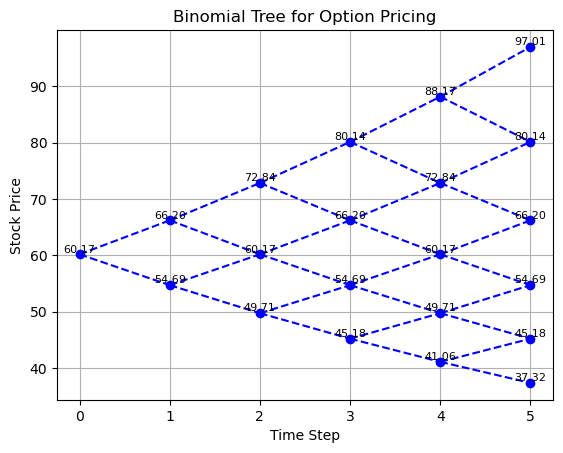

Option Values at Final Nodes (European Put):
 [[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          3.7984704 ]
 [ 0.          0.          0.          0.          0.         15.3120053 ]
 [ 0.          0.          0.          0.          0.         24.8231471 ]
 [ 0.          0.          0.          0.          0.         32.68014489]]


In [199]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# Function to generate binomial tree
def generate_binomial_tree(S0, K, T, r, sigma, n):
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    
    tree = np.zeros((n+1, n+1))
    for j in range(n+1):
        for i in range(j+1):
            tree[i, j] = S0 * (u ** (j - i)) * (d ** i)
    
    return tree

# Function to calculate option value at each final node
def calculate_option_value(tree, K, option_type='call'):
    n = tree.shape[1] - 1
    option_values = np.zeros_like(tree)
    if option_type == 'call':
        for i in range(n+1):
            option_values[i, n] = max(0, tree[i, n] - K)
    elif option_type == 'put':
        for i in range(n+1):
            option_values[i, n] = max(0, K - tree[i, n])
    return option_values

# Plot binomial tree
def plot_binomial_tree(tree):
    n = tree.shape[1] - 1
    for j in range(n+1):
        for i in range(j+1):
            plt.plot(j, tree[i, j], 'bo')
            plt.text(j, tree[i, j], f'{tree[i, j]:.2f}', va='bottom', ha='center', fontsize=8)
    
    for j in range(n):
        for i in range(j+1):
            plt.plot([j, j+1], [tree[i, j], tree[i, j+1]], 'b--')
            plt.plot([j, j+1], [tree[i, j], tree[i+1, j+1]], 'b--')

    plt.xlabel('Time Step')
    plt.ylabel('Stock Price')
    plt.title('Binomial Tree for Option Pricing')
    plt.grid(True)
    plt.show()

# Parameters
S0 = 60.17
K = 70   # Strike price
T = 1      # Time to expiration (1 year)
r = 0.043   # Risk-free rate
sigma = annualized_std_dev   # Volatility
n = 5      # Number of steps in the binomial tree

# Generate binomial tree
tree = generate_binomial_tree(S0, K, T, r, sigma, n)
plot_binomial_tree(tree)

# Calculate option value at each final node for a European put
option_values_put = calculate_option_value(tree, K, option_type='put')
print("Option Values at Final Nodes (European Put):\n", option_values_put)


# MONTE CARLO SIMULATION

In [25]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t])    
    return S

In [27]:
S0 = walmart_data['Adj Close'].iloc[-1]
T = 1
r = 0.043
sigma = 0.21
K = 50

In [28]:
S = mcs_simulation_np(1000)

In [29]:
S = np.transpose(S)
S

array([[60.16999817, 59.99367286, 59.96391564, ..., 54.57523287,
        54.63208661, 54.64706459],
       [60.16999817, 60.42731901, 60.81812973, ..., 49.90356813,
        49.89878834, 49.66070634],
       [60.16999817, 59.61412139, 59.08823502, ..., 73.33136678,
        72.4979075 , 72.71079765],
       ...,
       [60.16999817, 60.16770529, 60.57233661, ..., 64.51290669,
        64.39450953, 64.42650753],
       [60.16999817, 60.29090798, 60.46451376, ..., 57.63967552,
        58.40694167, 58.17913915],
       [60.16999817, 59.57304144, 59.35211776, ..., 50.79549516,
        50.41585958, 50.19063638]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

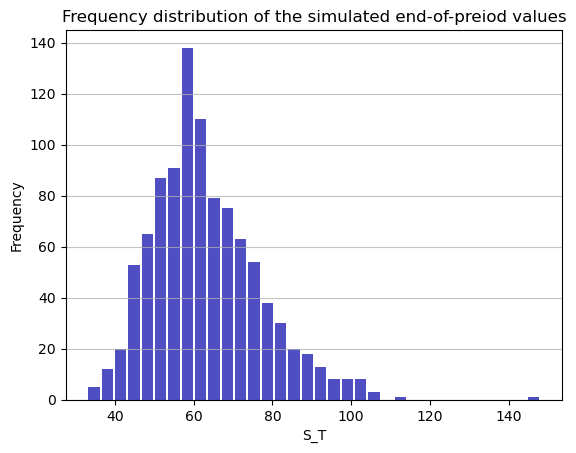

In [30]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

In [33]:
p = np.exp(-r*T)*np.mean(np.maximum(K - S[:,-1],0))
print('European put', str(p))

European put 0.7322003048129437


# ANALYSIS OF THE GREEKS

## DELTA

In [131]:
def delta(S0, K, T, r, sigma, payoff):
    
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if payoff == "call":
        delta = si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  si.norm.cdf(d1, 0.0, 1.0)-1
    
    return delta

In [136]:
delta(60.19, 70 , 1, 0.043, annualized_std_dev , 'call')

0.3450440780722187

In [137]:
delta(60.19, 50 , 1, 0.043, annualized_std_dev , 'put')

-0.11971173238650645

In [139]:
S = np.linspace(50,150,11)
Delta_Call = np.zeros((len(S),1))
Delta_Put = np.zeros((len(S),1))
for i in range(len(S)):
    Delta_Call [i] = delta(S[i], 60.17, 1, 0.043, annualized_std_dev, 'call')
    Delta_Put [i] = delta(S[i], 60.17, 1, 0.043, annualized_std_dev, 'put')

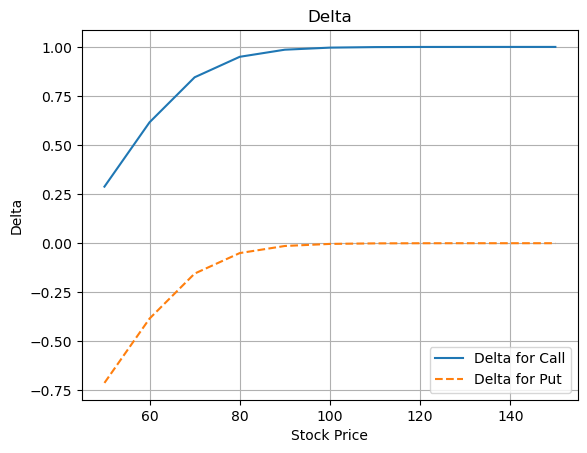

In [140]:
fig = plt.figure()
plt.plot(S, Delta_Call, '-')
plt.plot(S, Delta_Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Call','Delta for Put'])

In [149]:
S = np.linspace(50, 150, 51)
T = np.linspace(0.5, 2, 51)
Delta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Delta[i,j] = delta(S[j], 60.17, T[i], 0.043, annualized_std_dev, 'put')

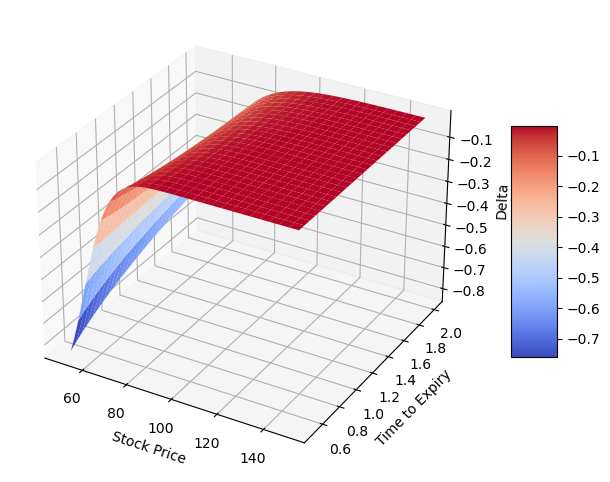

In [150]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection = '3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Delta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
#rstride: the array of row stride (step size) cstride: the array of column stride.
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [151]:
d = delta(60.17, 50, 1, 0.04, 0.3, 'put')
print('The value of Delta is', d.round(4),'.','If the stock price increase 1 dollar, then the value of the option will increase $', d.round(4), '.')

The value of Delta is -0.1839 . If the stock price increase 1 dollar, then the value of the option will increase $ -0.1839 .


## GAMMA

In [148]:
def gamma(S0, K, T, r,  sigma, payoff):
    
    d1 = (np.log(S0 / K) + (r  + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    gamma = si.norm.pdf(d1, 0.0, 1.0) / (sigma *  np.sqrt(T) * S0)

    
    
    return gamma

In [152]:
S = np.linspace(50, 150, 51)
T = np.linspace(0.5, 2, 51)
Gamma = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Gamma[i,j] = gamma(S[j], 60.17, T[i], 0.043, annualized_std_dev, 'put')

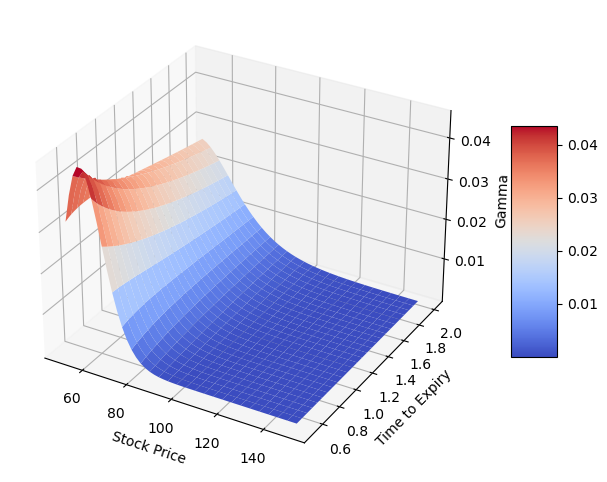

In [153]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection = '3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Gamma, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [154]:
gamma(60.17, 50, 1, 0.043, annualized_std_dev, 'call')

0.015565837636145323

In [156]:
gamma(60.17, 70, 1, 0.043, annualized_std_dev, 'put')

0.02864920421578174

In [157]:
S = np.linspace(50,150,11)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i], 60.17, 1, 0.043, annualized_std_dev, 'put')

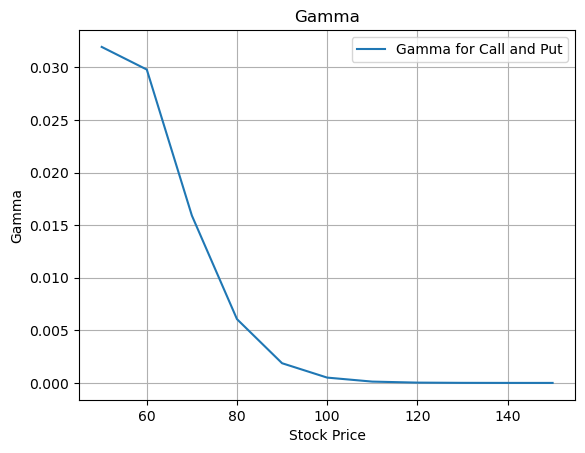

In [158]:
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Call and Put'])

## THETA

In [163]:
def theta(S0, K, T, r, sigma, payoff):
    
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    N_d1_prime=1/np.sqrt(2 * np.pi) * np.exp(-d1**2/2)
    
    if payoff == "call":
        theta = - S0 * N_d1_prime * sigma / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = - S0 * N_d1_prime * sigma / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [164]:
theta(60.17, 50, 1, 0.043, annualized_std_dev, 'call')

-2.99880733233345

In [165]:
theta(60.17, 70, 1, 0.043, annualized_std_dev, 'put')

-0.260549214054266

In [167]:
T = np.linspace(annualized_std_dev,3,12)
Theta_Call = np.zeros((len(T),1))
Theta_Put = np.zeros((len(T),1))
for i in range(len(T)):
    Theta_Call [i] = theta(60.17, 50, T[i], 0.043, annualized_std_dev, 'call')
    Theta_Put [i] = theta(60.17, 70, T[i], 0.043, annualized_std_dev, 'put')

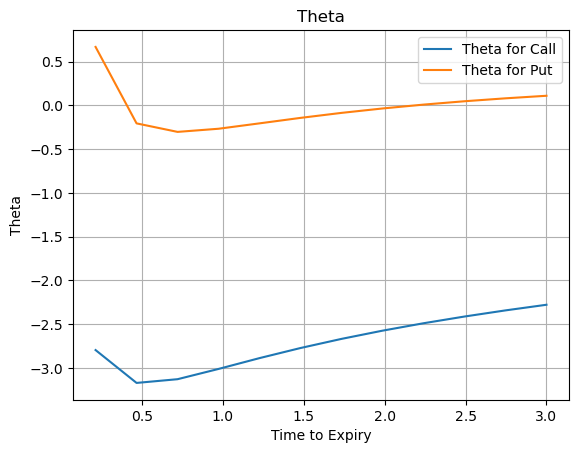

In [168]:
fig = plt.figure()
plt.plot(T, Theta_Call, '-')
plt.plot(T, Theta_Put, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Call', 'Theta for Put'])

In [183]:
S = np.linspace(50, 150, 51)
T = np.linspace(0.5, 2, 51)
Theta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Theta[i,j] = theta(S[j], 60.17, T[i], 0.043, annualized_std_dev, 'call')

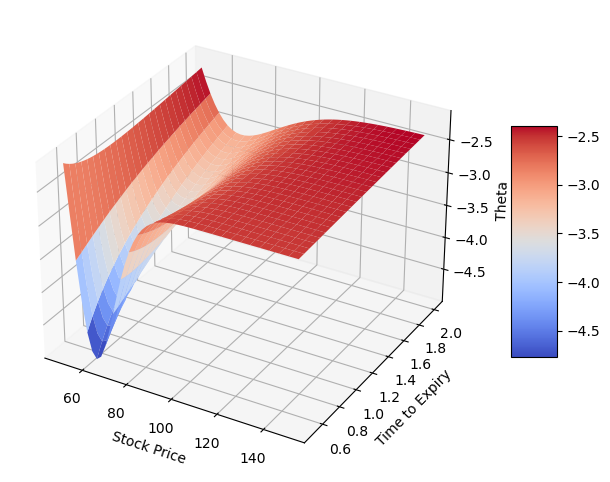

In [184]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection = '3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Theta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);

## VEGA

# 

In [ ]:
def vega(S0, K, T, r, sigma, payoff):
    
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    N_d1_prime=1/np.sqrt(2 * np.pi) * np.exp(-d1**2/2)
    vega = S0 * np.sqrt(T) * N_d1_prime
    
    return vega

In [186]:
vega(60.17, 50, 1, 0.043, annualized_std_dev, 'call')

12.03804161620475

In [187]:
vega(60.17, 70, 1, 0.043, annualized_std_dev, 'put')

22.156232172169457

In [188]:
sigma = np.linspace(0.1,0.4,13)
Vega = np.zeros((len(sigma),1))
for i in range(len(sigma)):
    Vega [i] = vega(60.17, 50, 1, 0.043, sigma[i], 'call')

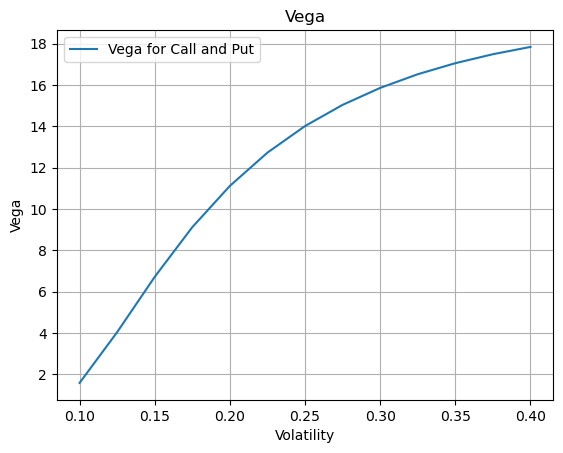

In [189]:
fig = plt.figure()
plt.plot(sigma, Vega, '-')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega for Call and Put'])

In [190]:
S = np.linspace(50, 150, 51)
T = np.linspace(0.5, 2, 51)
Vega = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Vega[i,j] = vega(S[j], 105, T[i], 0.043, annualized_std_dev, 'call')

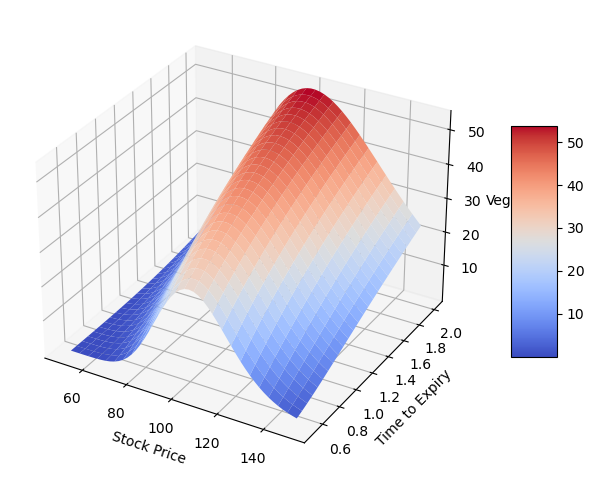

In [191]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection = '3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Vega, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Vega')
fig.colorbar(surf, shrink=0.5, aspect=5);